# Árboles de decisión, Random Forest, Adaboost, KNN Coarse (Número de vecinos alto para decidir entre 10 a 100).

## Decision Tree

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 8}
Training time: 13.55 seconds

### Cross-Validation Metrics (10 folds) ###
Cross-Validation Accuracy: 0.84 ± 0.06
Cross-Validation Precision: 0.86 ± 0.05
Cross-Validation Recall: 0.84 ± 0.06
Cross-Validation F1-Score: 0.84 ± 0.06

### Test Set Metrics ###
Test Accuracy: 0.86
Test Precision: 0.88
Test Recall: 0.86
Test F1-Score: 0.86


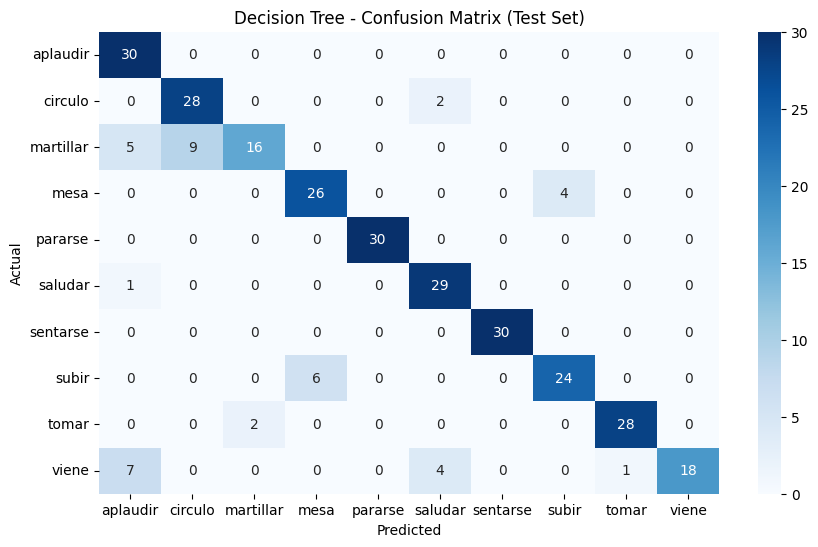

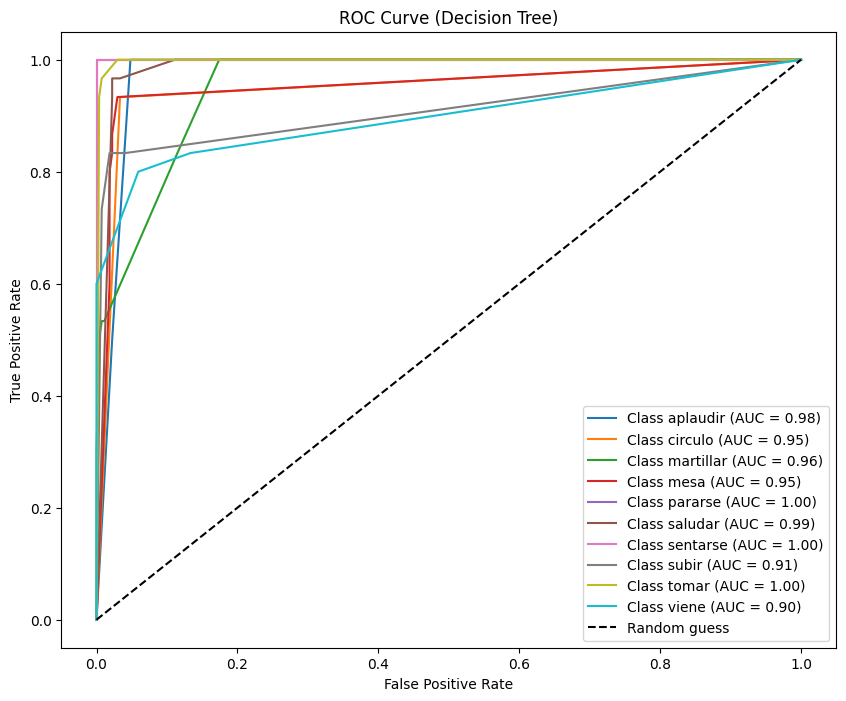

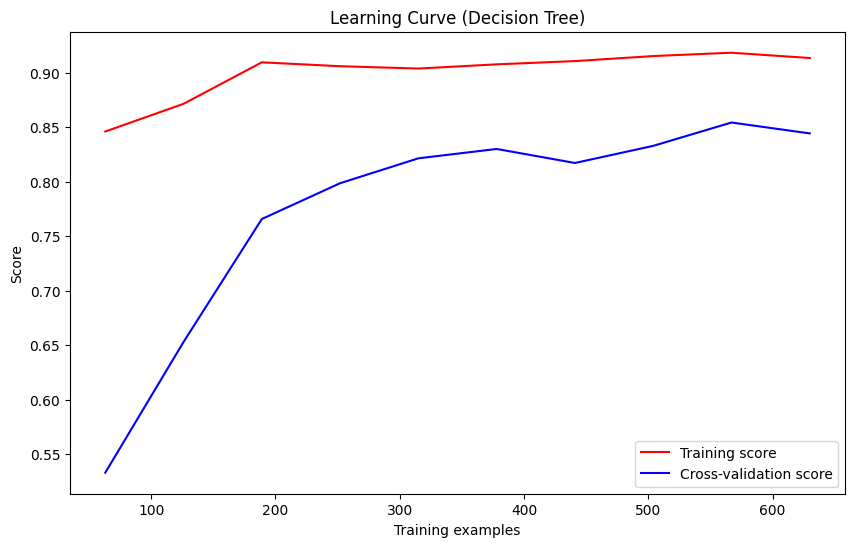

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Hiperparámetros para la búsqueda aleatoria
param_dist = {
    'max_depth': randint(1, 6),  # Reducir la profundidad máxima
    'min_samples_split': randint(5, 20),  # Aumentar los requisitos mínimos de división
    'min_samples_leaf': randint(5, 20),  # Requerir más muestras por hoja
    'criterion': ['gini', 'entropy']
}


classifier = DecisionTreeClassifier(random_state=0)

# Configurar 10 pliegos para RandomizedSearchCV
cv_random_search = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=50, cv=cv_random_search, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Mejores hiperparámetros encontrados
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada con 10 pliegos para evaluar el modelo
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métricas de validación cruzada
cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
cv_precision = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='precision_weighted', n_jobs=-1)
cv_recall = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='recall_weighted', n_jobs=-1)
cv_f1 = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

print("\n### Cross-Validation Metrics (10 folds) ###")
print(f"Cross-Validation Accuracy: {cv_accuracy.mean():.2f} ± {cv_accuracy.std():.2f}")
print(f"Cross-Validation Precision: {cv_precision.mean():.2f} ± {cv_precision.std():.2f}")
print(f"Cross-Validation Recall: {cv_recall.mean():.2f} ± {cv_recall.std():.2f}")
print(f"Cross-Validation F1-Score: {cv_f1.mean():.2f} ± {cv_f1.std():.2f}")

# Predicciones y probabilidades
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)

# Métricas del conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("\n### Test Set Metrics ###")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Decision Tree - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje usando los mejores hiperparámetros
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (Decision Tree)")
plt.legend()
plt.show()

## Random Forest


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 76}
Training time: 121.01 seconds

Cross-Validation Scores: [0.88571429 0.95714286 0.91428571 0.85714286 0.98571429 0.91428571
 0.91428571 0.94285714 0.9        0.95714286]
Mean CV Accuracy: 0.92
Standard Deviation of CV Accuracy: 0.04

### Model Performance Metrics (Test Set) ###
Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1-Score: 0.92


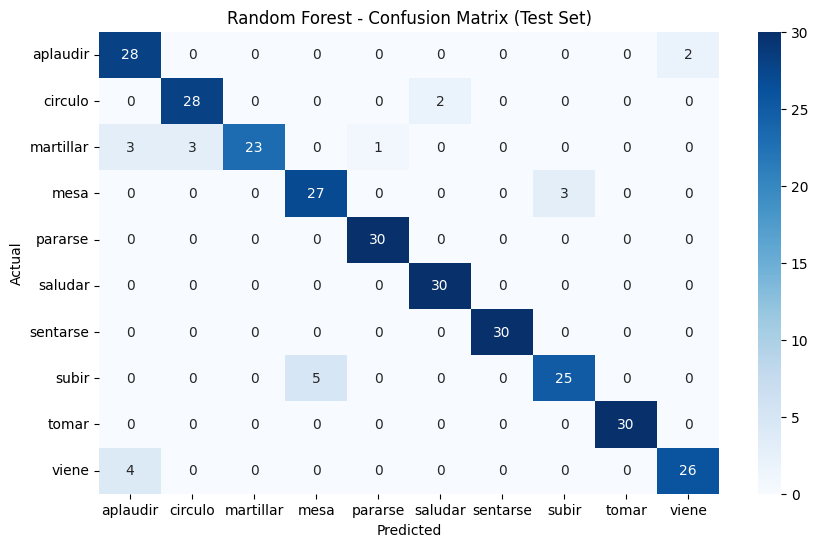

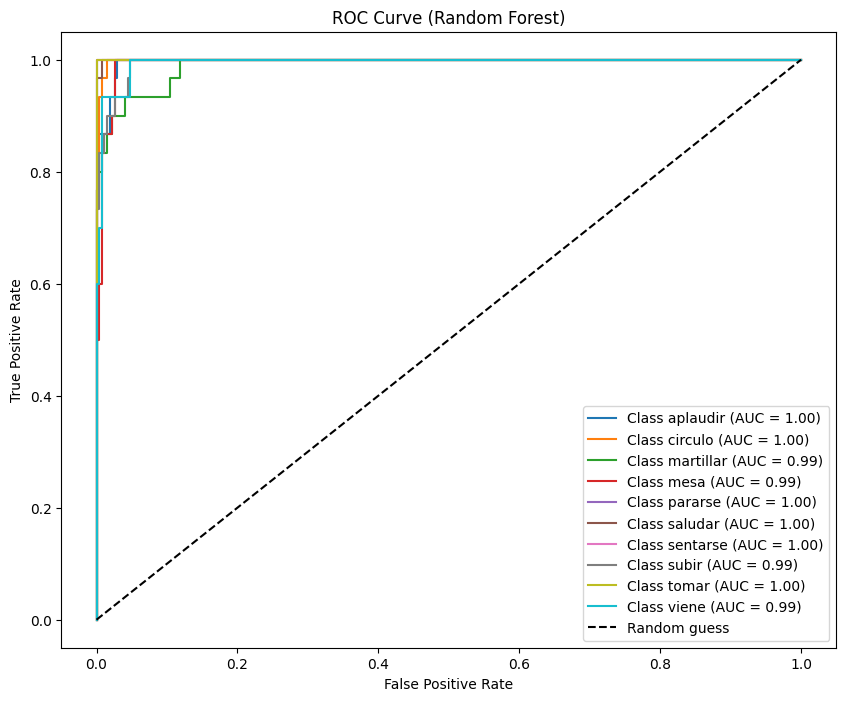

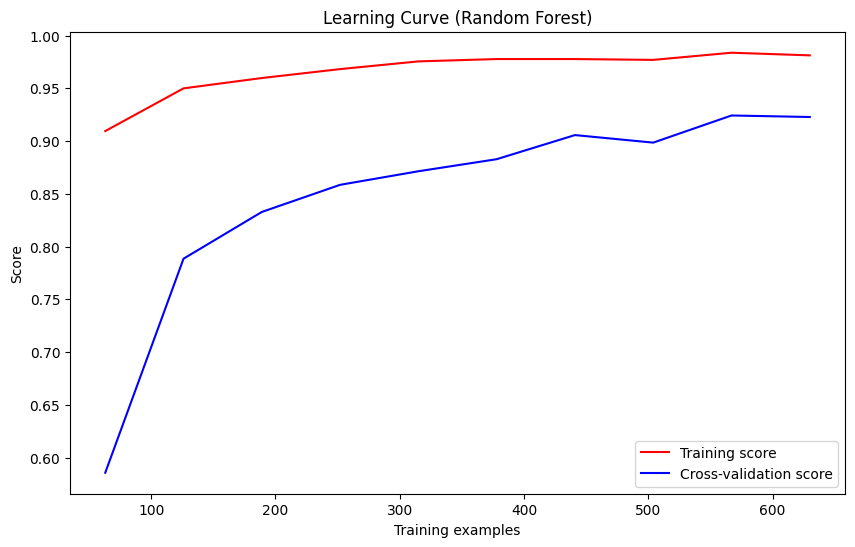

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Hiperparámetros para la búsqueda aleatoria
param_dist = {
    'n_estimators': randint(50, 100),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(5, 20),
    'min_samples_leaf': randint(5, 15),
    'bootstrap': [True]
}

classifier = RandomForestClassifier(random_state=0)

# Validación cruzada a 10 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=50, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Mejores hiperparámetros encontrados
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada con 10 pliegos en el conjunto de entrenamiento
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")

# Métricas del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Model Performance Metrics (Test Set) ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Random Forest - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()

# Curva de aprendizaje con los mejores hiperparámetros
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.show()

## Adaboost

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4}
Training time: 14.14 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.8        0.85714286 0.82857143 0.81428571 0.81428571 0.87142857
 0.71428571 0.85714286 0.81428571 0.8       ]
Mean accuracy: 0.82
Standard deviation: 0.04

### Test Set Performance Metrics ###
Accuracy: 0.83
Precision: 0.86
Recall: 0.83
F1-Score: 0.82


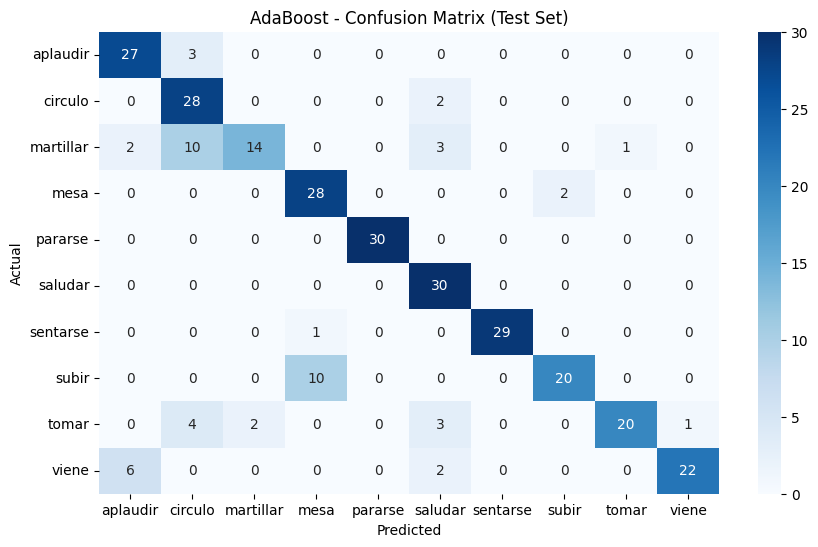

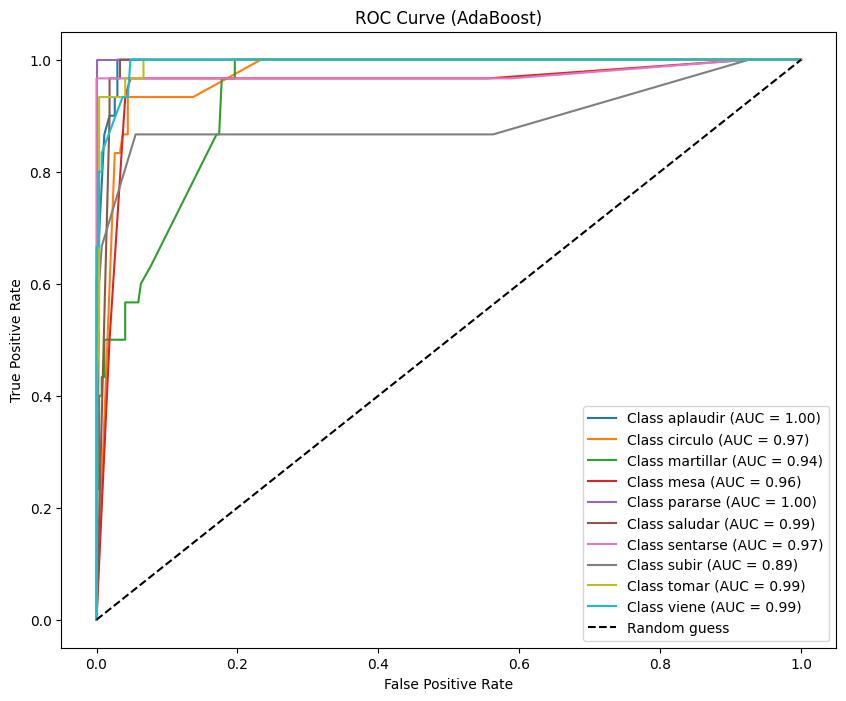

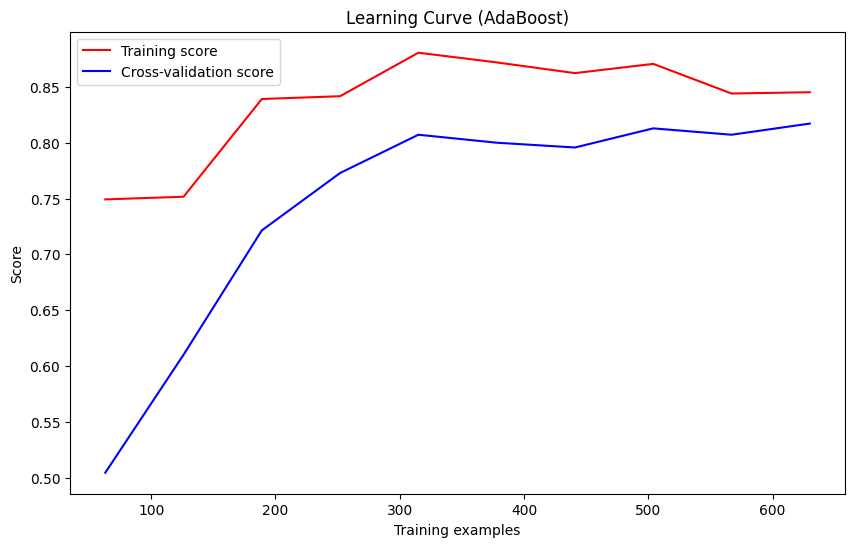

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Hiperparámetros para RandomizedSearchCV
param_dist = {
    'max_depth': randint(1, 5),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3),
    'criterion': ['gini', 'entropy']
}

# Clasificador base para AdaBoost
classifier = DecisionTreeClassifier(random_state=0)

# Validación cruzada a 10 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Búsqueda aleatoria para optimizar el clasificador base
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=50, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

random_search.fit(X_train, y_train)
best_base_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# AdaBoost con el mejor clasificador base y algoritmo SAMME
clf = AdaBoostClassifier(
    estimator=best_base_model,
    n_estimators=20,
    learning_rate=0.01,
    algorithm='SAMME',
    random_state=42
)

clf.fit(X_train, y_train)

# Validación cruzada a 10 pliegos
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('AdaBoost - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AdaBoost)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (AdaBoost)")
plt.legend()
plt.show()

## KNN Coarse (Número de vecinos alto, para elegir entre 10 y 100)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Training time: 14.40 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.47142857 0.67142857 0.61428571 0.44285714 0.54285714 0.57142857
 0.54285714 0.58571429 0.65714286 0.52857143]
Mean accuracy: 0.56
Standard deviation: 0.07

### Test Set Performance Metrics ###
Accuracy: 0.59
Precision: 0.60
Recall: 0.59
F1-Score: 0.59


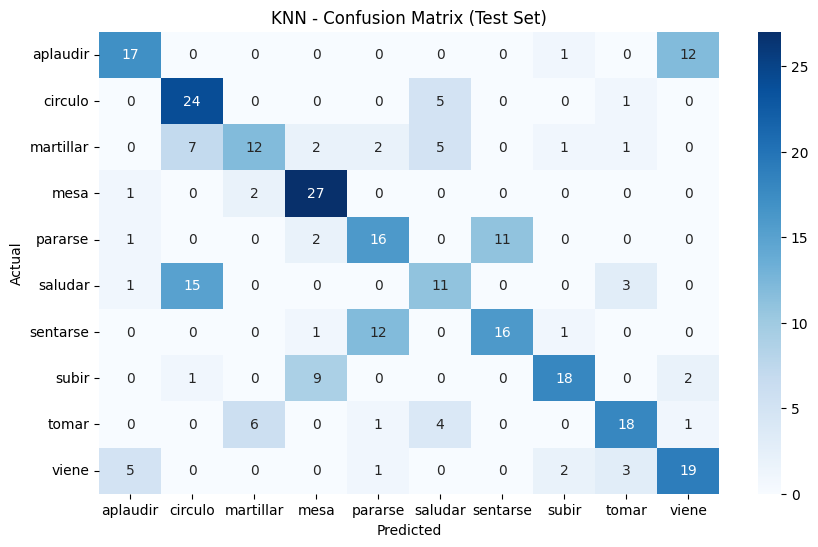

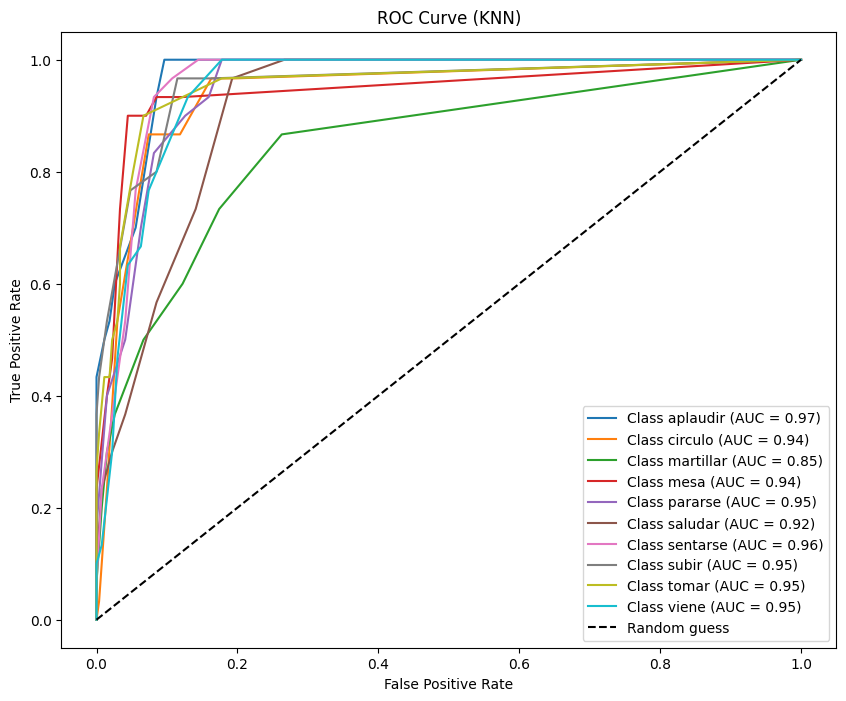

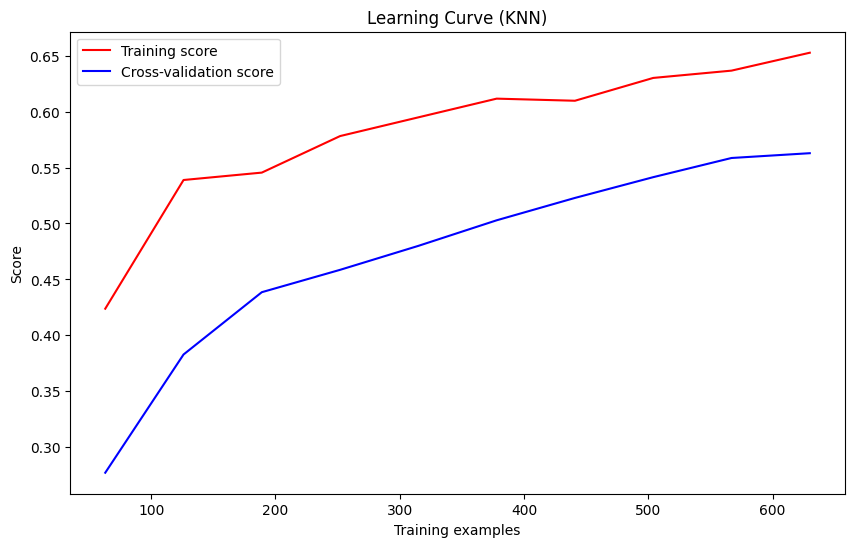

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Hiperparámetros para RandomizedSearchCV
param_dist = {
    'n_neighbors': randint(10, 101),  # Rango de vecinos (de 10 a 100)
    'weights': ['uniform'],  # Estrategias de ponderación
    'metric': ['euclidean']  # Métricas de distancia
}

# Inicializar clasificador KNN
classifier = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # Cambiado a 10 pliegos

# Búsqueda aleatoria para encontrar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=50, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

random_search.fit(X_train, y_train)
best_knn_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada a 10 pliegos
cross_val_scores = cross_val_score(best_knn_model, X_train, y_train, cv=cv, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)
y_pred_prob = best_knn_model.predict_proba(X_test)  # Probabilidades para la curva ROC

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('KNN - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (KNN)")
plt.legend()
plt.show()

# KNN Fine (Pocos vecinos muy cercanos para decidir, 1 a 3), KNN Minkowski, KNN Weighted, KNN Medium (Mediana).

## KNN Fine

Fitting 4 folds for each of 3 candidates, totalling 12 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Training time: 0.20 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.925  0.9125 0.925  0.9625 0.925  0.975  0.95   0.9375 0.925  0.975 ]
Mean accuracy: 0.94
Standard deviation: 0.02

### Test Set Performance Metrics ###
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94


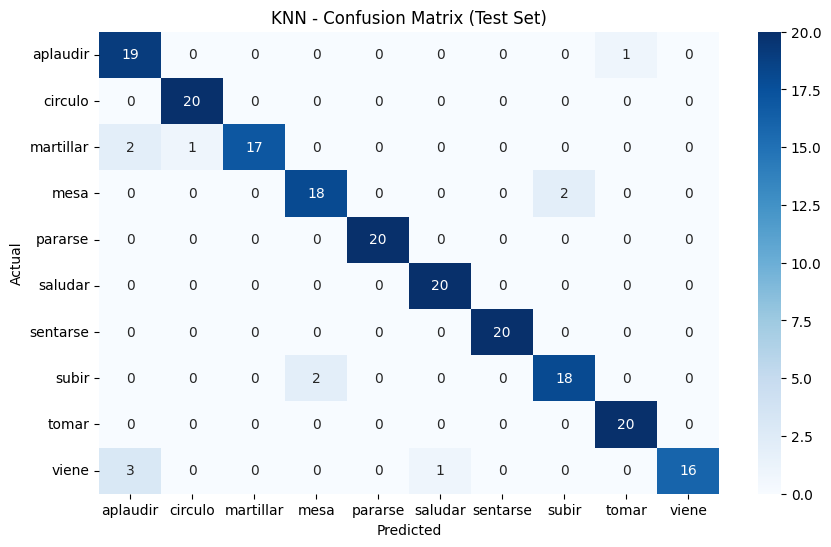

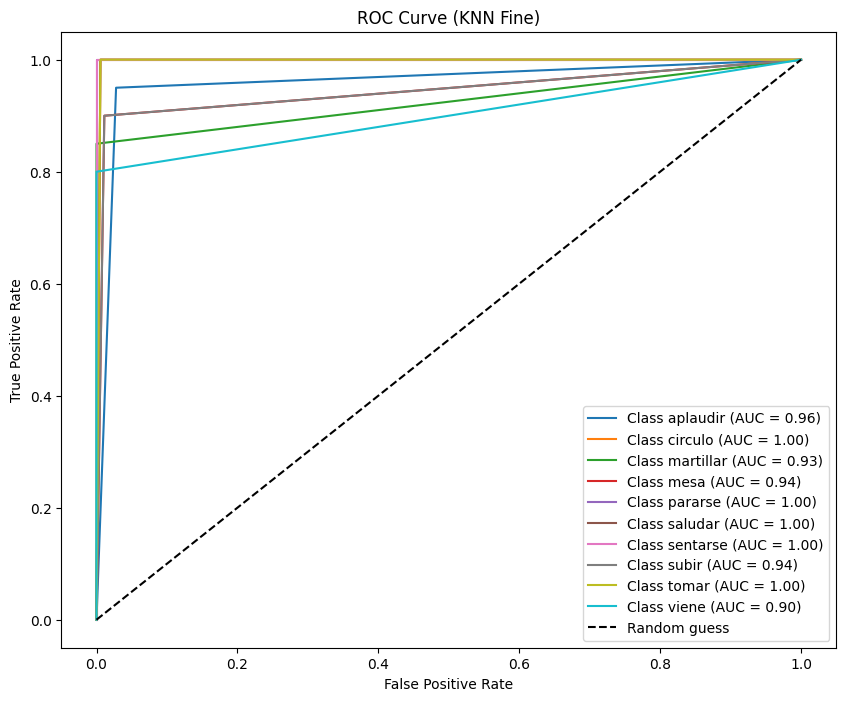

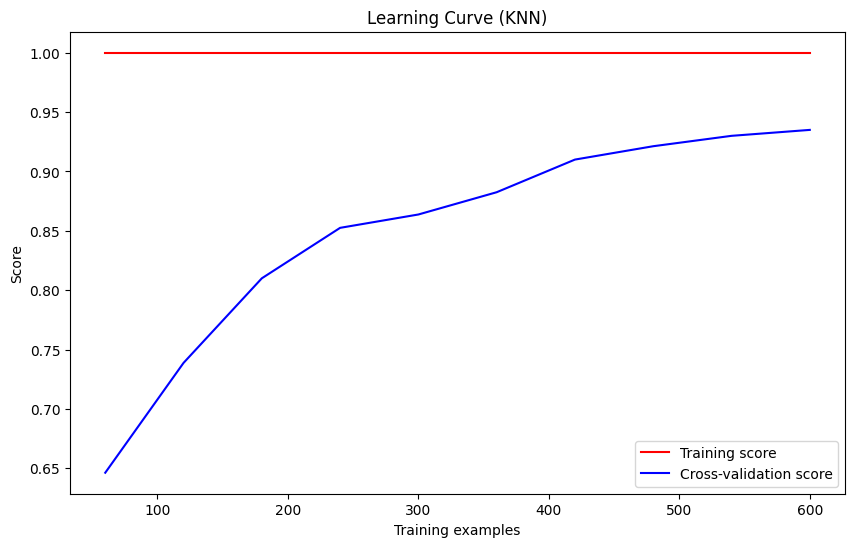

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Normalizar los datos
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para GridSearchCV
param_grid = {
    'n_neighbors': [1, 2, 3],         # Vecinos a considerar
    'weights': ['uniform'],  # Estrategias de ponderación
    'metric': ['euclidean']  # Métricas de distancia
}

# Inicializar clasificador KNN
classifier = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)  # 10 pliegos

# Búsqueda en rejilla para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,
                           cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Tiempo de entrenamiento
start_time = time.time()

grid_search.fit(X_train, y_train)
best_knn_model = grid_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada a 4 pliegos
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_knn_model, X_train, y_train, cv=cv_10, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)
y_pred_prob = best_knn_model.predict_proba(X_test)  # Probabilidades para la curva ROC


# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('KNN - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN Fine)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (KNN)")
plt.legend()
plt.show()

## KNN Minkowski

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best parameters found: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}
Training time: 4.48 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.8875 0.9125 0.925  0.9375 0.9125 0.9375 0.9125 0.925  0.875  0.9625]
Mean accuracy: 0.92
Standard deviation: 0.02

### Test Set Performance Metrics ###
Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1-Score: 0.94


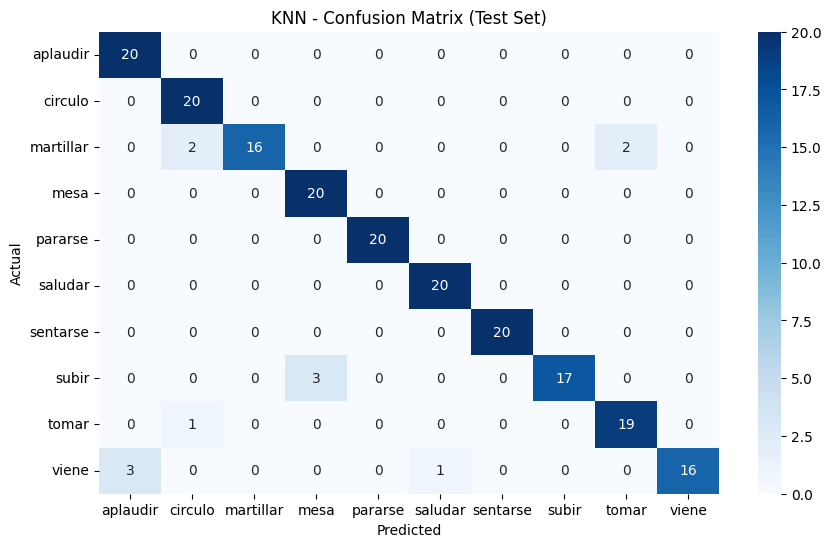

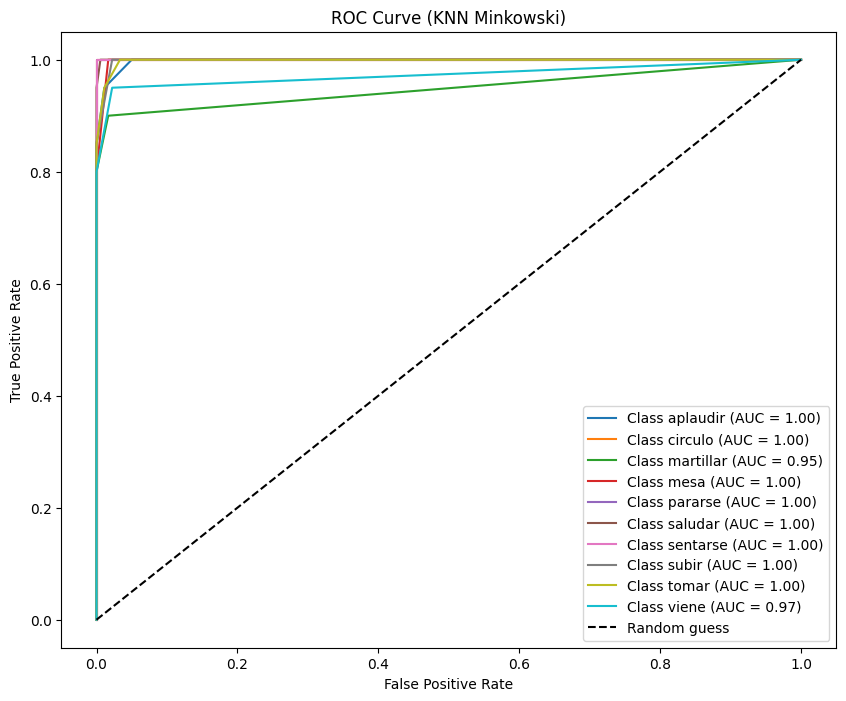

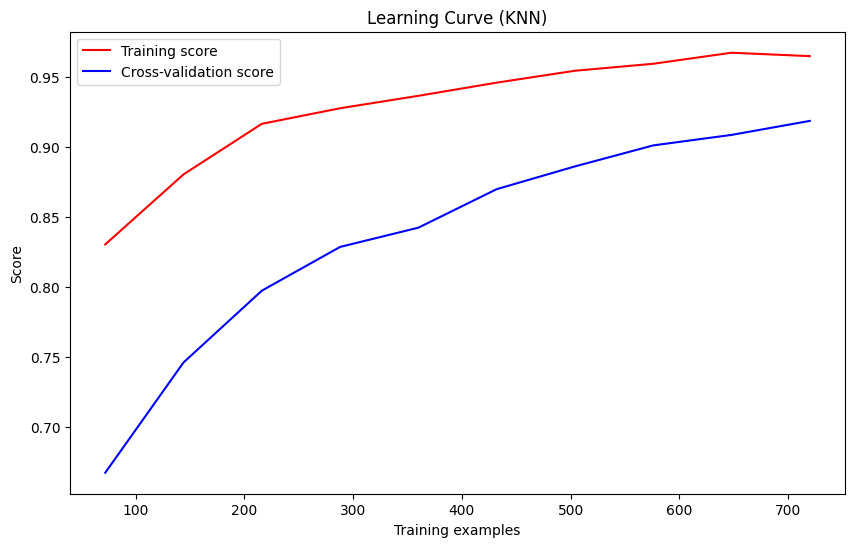

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta


# Normalizar los datos
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para GridSearchCV
param_grid = {
    'n_neighbors': (3,100),         # Vecinos a considerar
    'weights': ['uniform'],  # Estrategias de ponderación
    'metric': ['minkowski']  # Métricas de distancia
}

# Inicializar clasificador KNN
classifier = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # 10 pliegos

# Búsqueda en rejilla para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,
                           cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Tiempo de entrenamiento
start_time = time.time()

grid_search.fit(X_train, y_train)
best_knn_model = grid_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada a 4 pliegos
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_knn_model, X_train, y_train, cv=cv_10, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)
y_pred_prob = best_knn_model.predict_proba(X_test)  # Probabilidades para la curva ROC

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('KNN - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN Minkowski)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (KNN)")
plt.legend()
plt.show()

## KNN Weighted

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Training time: 0.16 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.91  0.93  0.96  0.905]
Mean accuracy: 0.93
Standard deviation: 0.02

### Test Set Performance Metrics ###
Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1-Score: 0.94


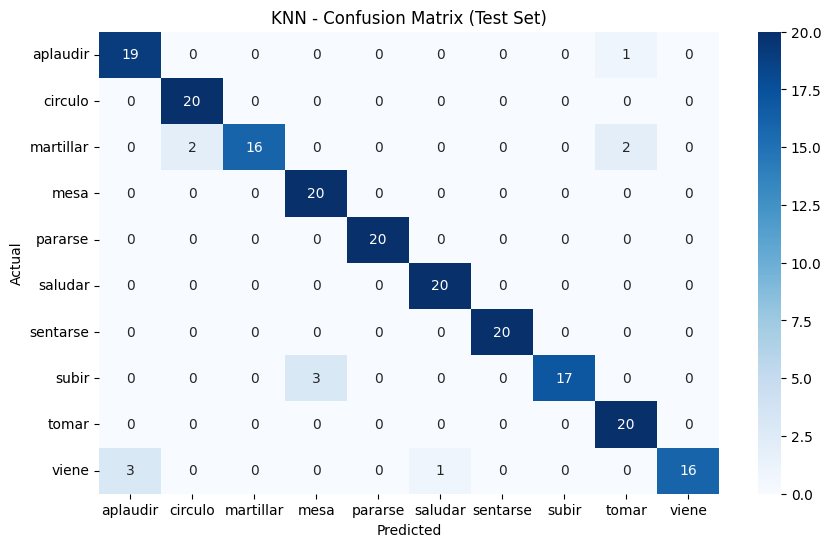

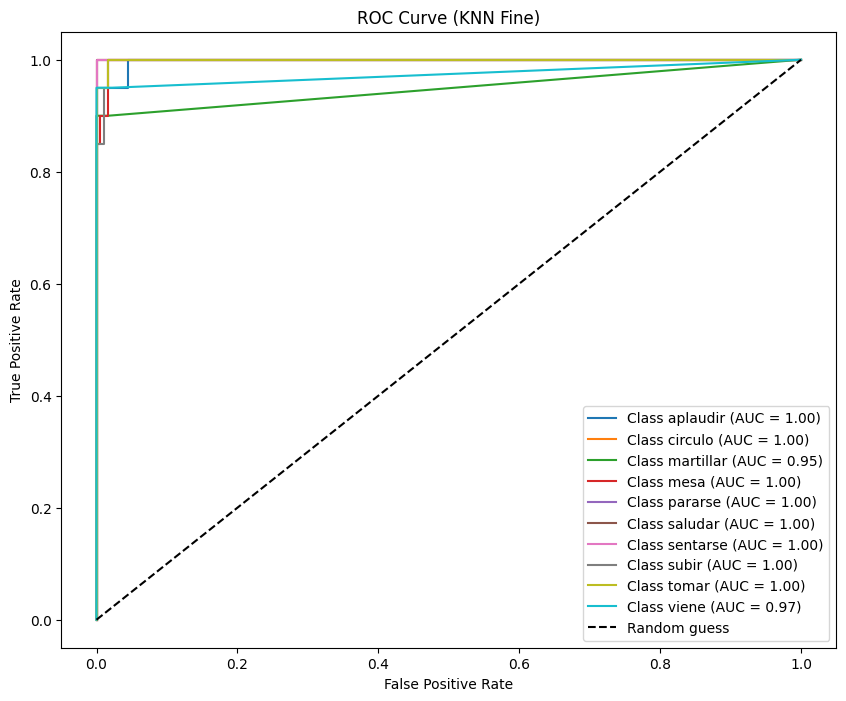

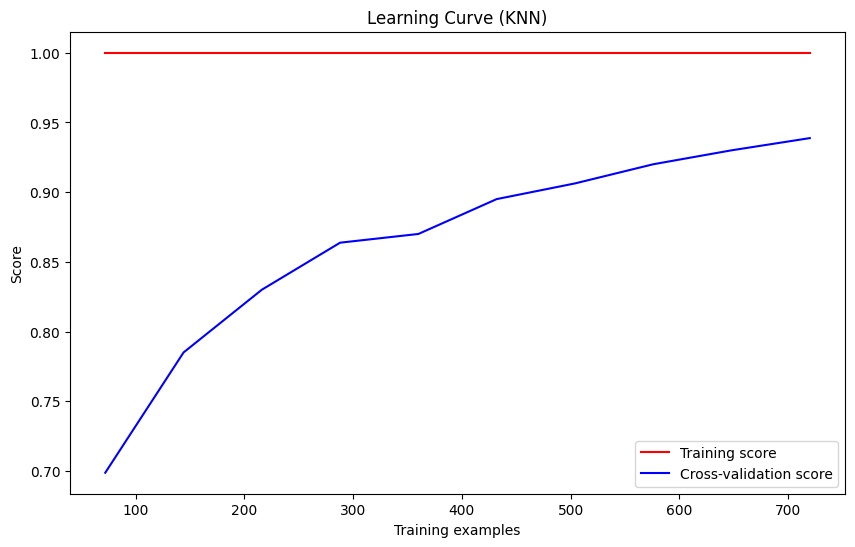

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Normalizar los datos
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para GridSearchCV
param_grid = {
    'n_neighbors': (3,100),         # Vecinos a considerar
    'weights': ['distance'],  # Estrategias de ponderación
    'metric': ['euclidean']  # Métricas de distancia
}

# Inicializar clasificador KNN
classifier = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # 10 pliegos

# Búsqueda en rejilla para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,
                           cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Tiempo de entrenamiento
start_time = time.time()

grid_search.fit(X_train, y_train)
best_knn_model = grid_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada a 4 pliegos
cv_10 = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_knn_model, X_train, y_train, cv=cv_10, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)
y_pred_prob = best_knn_model.predict_proba(X_test)  # Probabilidades para la curva ROC

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('KNN - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN Fine)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (KNN)")
plt.legend()
plt.show()

## KKN Medium

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best parameters found: {'n_neighbors': 3, 'weights': 'uniform'}
Training time: 39.83 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.9375 0.925  0.9125 0.9125 0.9375 0.9375 0.925  0.9125 0.8625 0.9625]
Mean accuracy: 0.92
Standard deviation: 0.02

### Test Set Performance Metrics ###
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-Score: 0.90


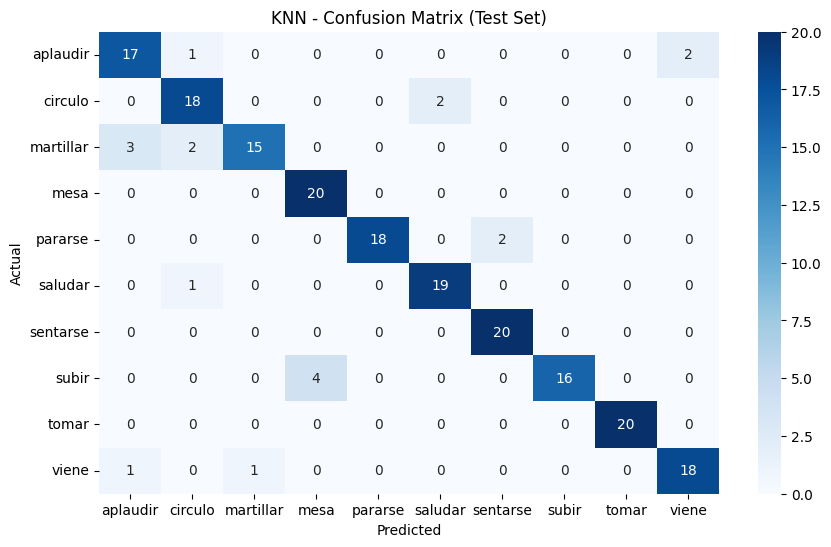

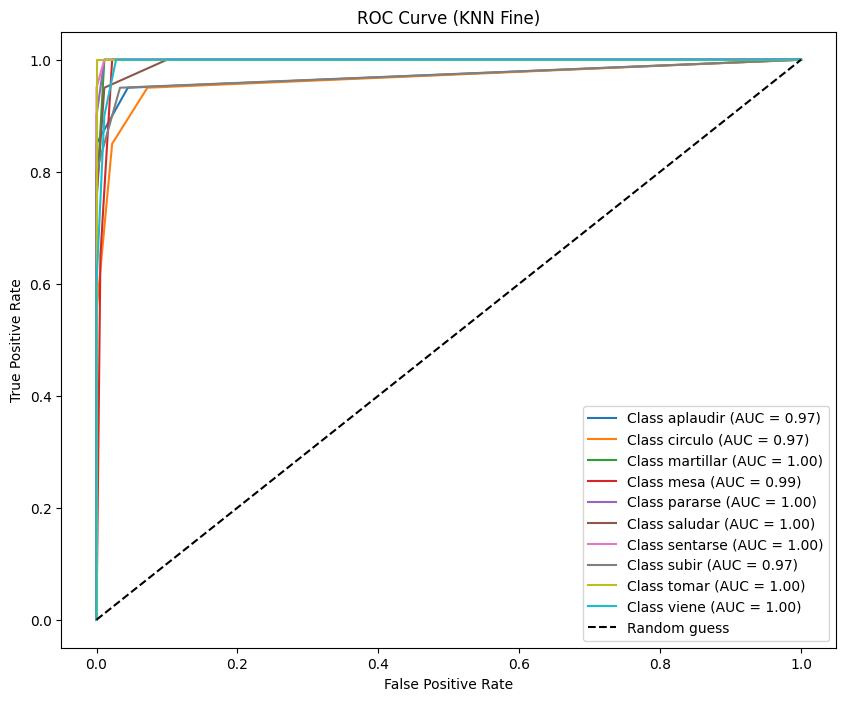

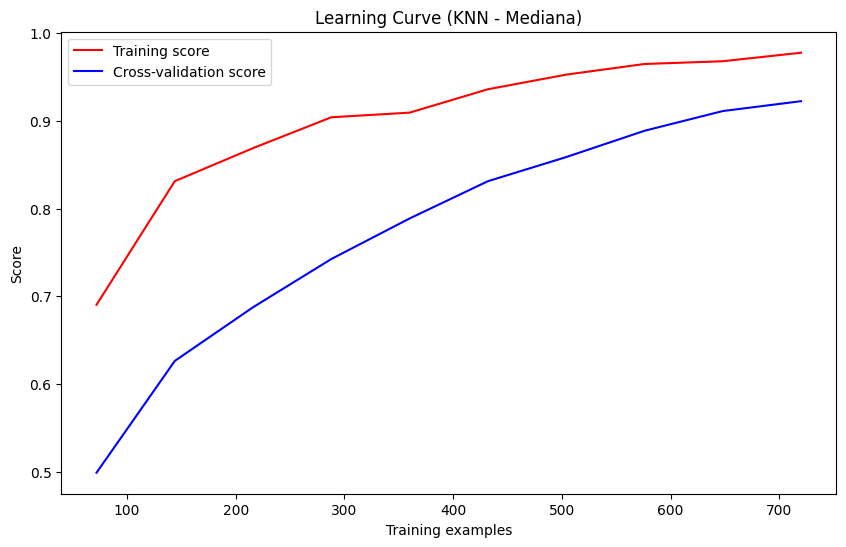

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Función personalizada para la distancia basada en la mediana
def median_distance(x1, x2):
    return np.median(np.abs(x1 - x2))

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Normalizar los datos
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para GridSearchCV
param_grid = {
    'n_neighbors': (3,100),         # Vecinos a considerar
    'weights': ['uniform']  # Estrategias de ponderación
}

# Inicializar clasificador KNN con métrica personalizada
classifier = KNeighborsClassifier(metric=median_distance)

# Definir validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Búsqueda en rejilla para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,
                           cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Tiempo de entrenamiento
start_time = time.time()

grid_search.fit(X_train, y_train)
best_knn_model = grid_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada a 10 pliegos
cross_val_scores = cross_val_score(best_knn_model, X_train, y_train, cv=cv, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)
y_pred_prob = best_knn_model.predict_proba(X_test)  # Probabilidades para la curva ROC

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('KNN - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN Fine)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (KNN - Mediana)")
plt.legend()
plt.show()


# Naive Bayes Gaussian, Naive Bayes Kernel, LDA, KNN Cosine.

## Naive Bayes Gaussian

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters found: {'var_smoothing': 0.0001}
Training time: 1.02 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.9375 0.9625 0.9375 0.9625 0.875  0.975  0.9125 0.9375 0.9125 0.9   ]
Mean accuracy: 0.93
Standard deviation: 0.03

### Test Set Performance Metrics ###
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94


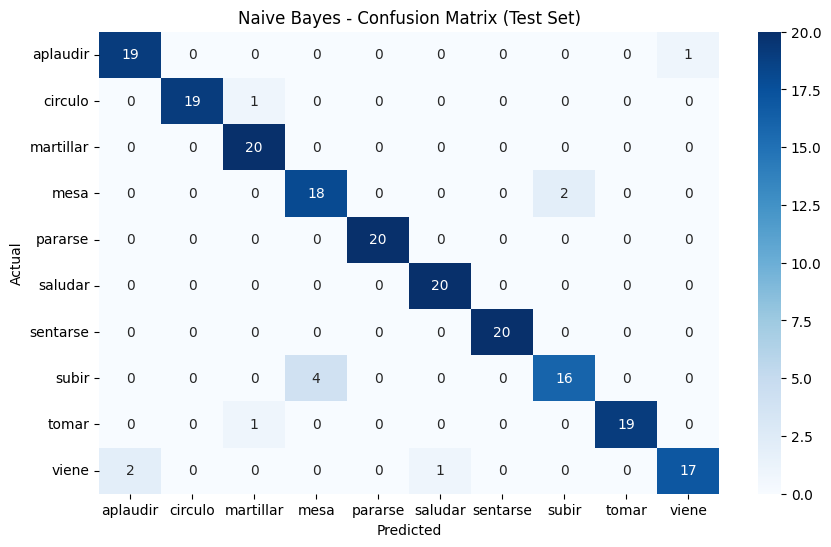

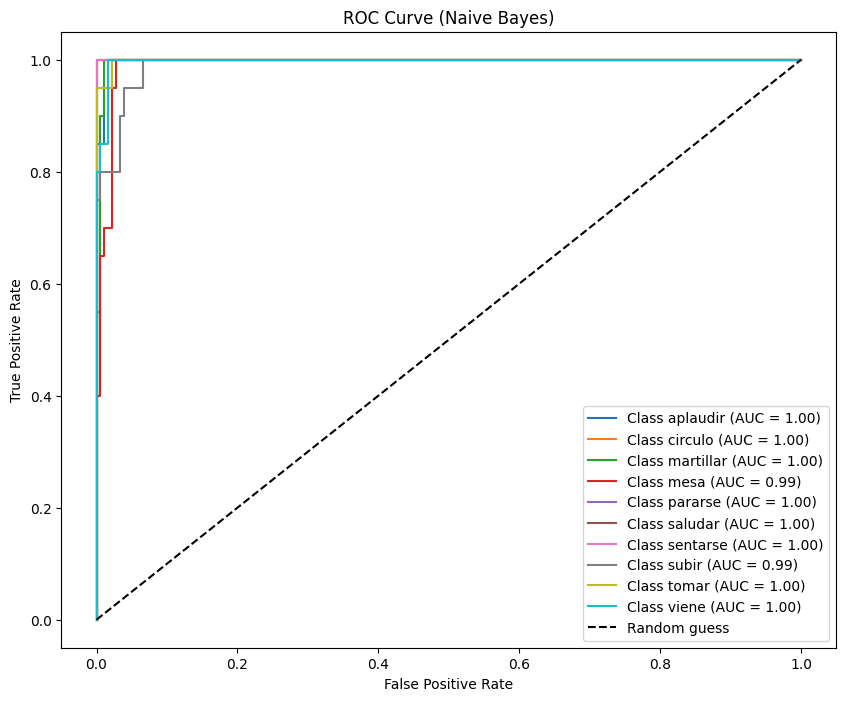

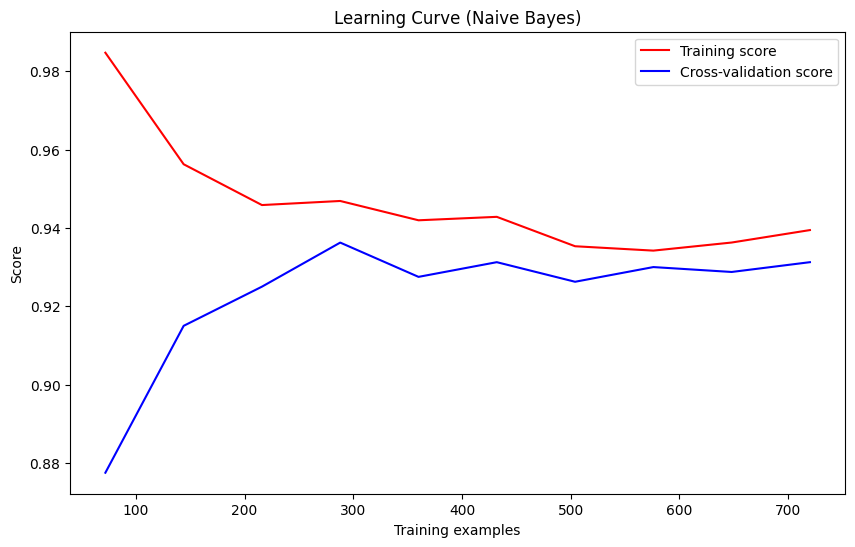

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Aplicación de LDA
lda = LinearDiscriminantAnalysis(n_components=9)
X_lda = lda.fit_transform(X, y)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para RandomizedSearchCV
param_dist = {
    'var_smoothing': np.logspace(0, -9, 10)  # Varianza de suavizado en Naive Bayes
}

# Inicializar clasificador Naive Bayes Gaussiano
classifier = GaussianNB()

# Inicialización de la búsqueda aleatoria para encontrar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=10, cv=10, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

# Entrenar el modelo con la búsqueda aleatoria
random_search.fit(X_train, y_train)
best_nb_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # Cambiado a 10 pliegos
cross_val_scores = cross_val_score(best_nb_model, X_train, y_train, cv=cv, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_nb_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Naive Bayes - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_prob = best_nb_model.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes)')
plt.legend(loc='lower right')
plt.show()


# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_nb_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (Naive Bayes)")
plt.legend()
plt.show()


## Naive Bayes Kernel

Cross-Validation Accuracy: 0.93 ± 0.03
Cross-Validation Precision: 0.94 ± 0.03
Cross-Validation Recall: 0.93 ± 0.03
Cross-Validation F1 Score: 0.93 ± 0.03

Test Accuracy: 0.95
Test Precision: 0.95
Test Recall: 0.95
Test F1 Score: 0.95
Training time: 0.05 seconds


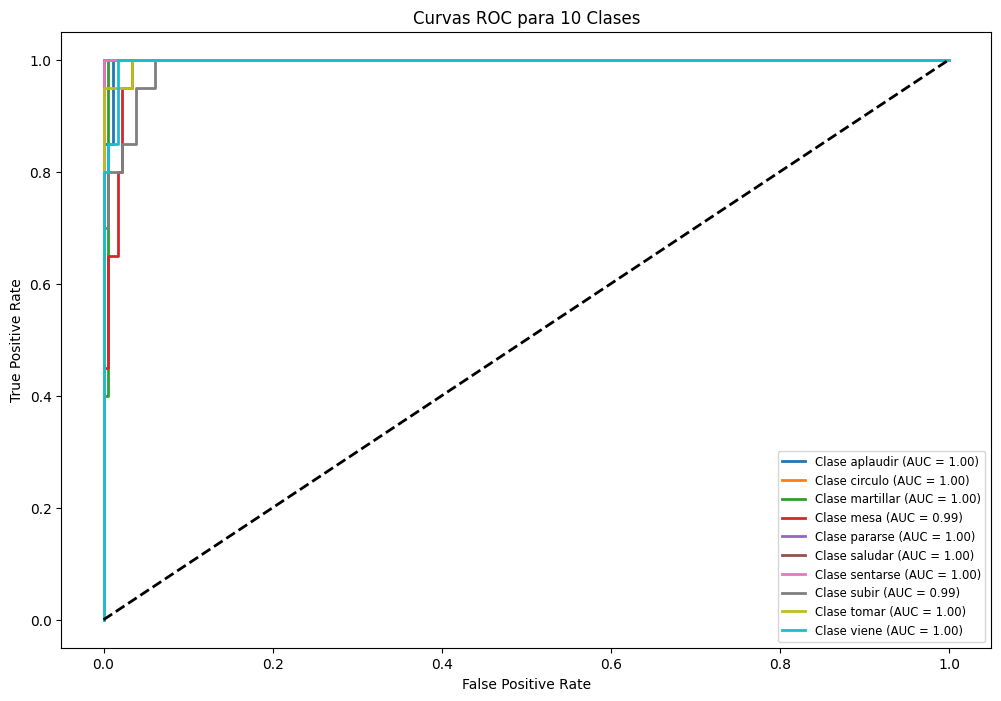

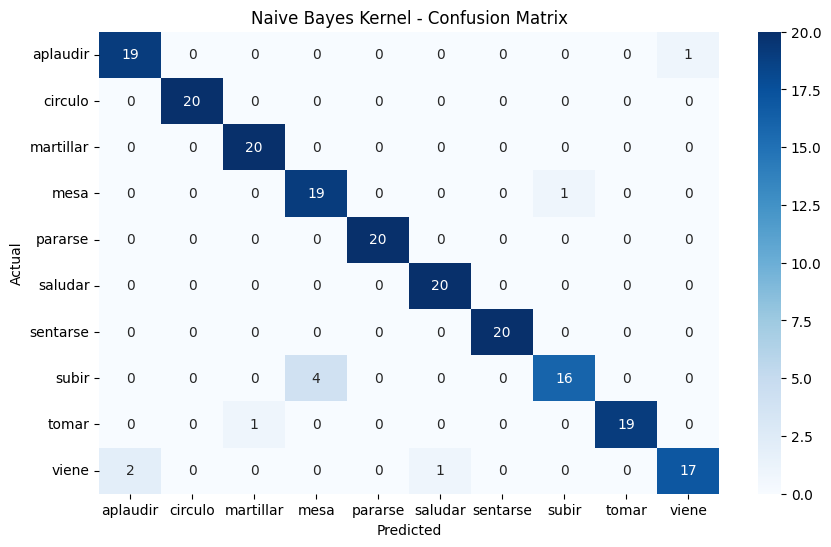

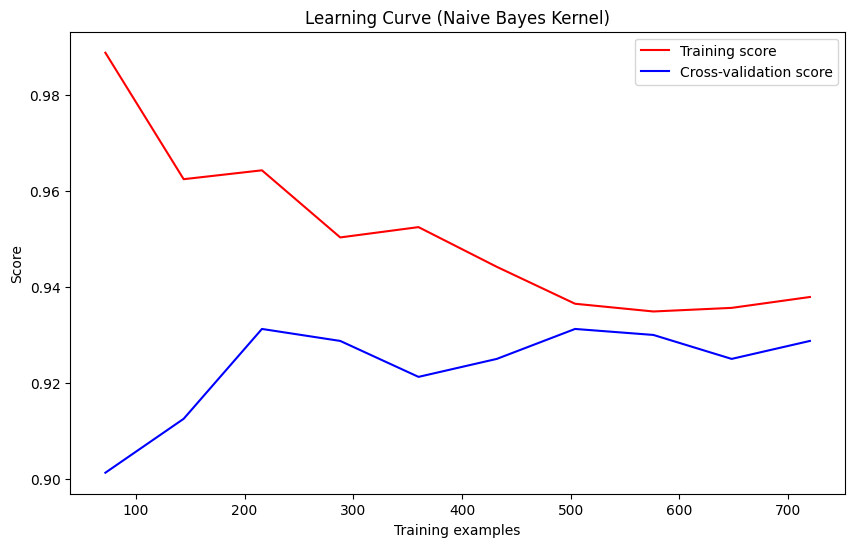

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import time
import pandas as pd

# Clase para implementar Naive Bayes Kernelizado
class NaiveBayesKernelized(BaseEstimator, ClassifierMixin):
    def __init__(self, bandwidth=0.5):
        self.bandwidth = bandwidth
        self.kde_models = {}
        self.priors = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)

        # Para cada clase, ajustamos un KernelDensity para cada característica
        for cls in self.classes_:
            X_cls = X[y == cls]
            kde_list = []
            # Ajustar un modelo KDE por cada característica
            for feature in range(X.shape[1]):
                kde = KernelDensity(kernel="gaussian", bandwidth=self.bandwidth).fit(X_cls[:, feature].reshape(-1, 1))
                kde_list.append(kde)
            self.kde_models[cls] = kde_list
            self.priors[cls] = len(X_cls) / len(X)
        return self

    def predict(self, X_test):
        predictions = []

        # Realizamos la predicción para cada muestra
        for x in X_test:
            scores = {}
            for cls in self.classes_:
                log_likelihood = np.log(self.priors[cls])

                # Para cada clase, sumamos los logaritmos de las densidades
                for i, kde in enumerate(self.kde_models[cls]):
                    log_likelihood += kde.score_samples([[x[i]]])[0]

                scores[cls] = log_likelihood

            # Predecir la clase con mayor log-verosimilitud
            predictions.append(max(scores, key=scores.get))

        return np.array(predictions)

    def predict_proba(self, X_test):
        # Para la curva ROC necesitamos las probabilidades, no las clases
        probas = np.zeros((X_test.shape[0], len(self.classes_)))
        for i, x in enumerate(X_test):
            for j, cls in enumerate(self.classes_):
                log_likelihood = np.log(self.priors[cls])
                for k, kde in enumerate(self.kde_models[cls]):
                    log_likelihood += kde.score_samples([[x[k]]])[0]
                probas[i, j] = np.exp(log_likelihood)  # Probabilidad es el exponente del logaritmo
        probas /= probas.sum(axis=1, keepdims=True)  # Normalizar para que las probabilidades sumen a 1
        return probas

# Cargar los datos
data = pd.read_csv('dataset.csv')
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
# Aplicación de LDA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_scaled, y)

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Crear el clasificador Naive Bayes Kernelizado
nbk_clf = NaiveBayesKernelized(bandwidth=0.5)

# Validación cruzada con 4 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Obtener las métricas mediante validación cruzada
cross_val_scores = cross_val_score(nbk_clf, X_train, y_train, cv=cv, scoring='accuracy')
cross_val_precision = cross_val_score(nbk_clf, X_train, y_train, cv=cv, scoring='precision_weighted')
cross_val_recall = cross_val_score(nbk_clf, X_train, y_train, cv=cv, scoring='recall_weighted')
cross_val_f1 = cross_val_score(nbk_clf, X_train, y_train, cv=cv, scoring='f1_weighted')

# Mostrar los resultados de la validación cruzada
print(f"Cross-Validation Accuracy: {np.mean(cross_val_scores):.2f} ± {np.std(cross_val_scores):.2f}")
print(f"Cross-Validation Precision: {np.mean(cross_val_precision):.2f} ± {np.std(cross_val_precision):.2f}")
print(f"Cross-Validation Recall: {np.mean(cross_val_recall):.2f} ± {np.std(cross_val_recall):.2f}")
print(f"Cross-Validation F1 Score: {np.mean(cross_val_f1):.2f} ± {np.std(cross_val_f1):.2f}")

# Tiempo de entrenamiento
start_time = time.time()
nbk_clf.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

# Predicción y evaluación en el conjunto de prueba
y_pred = nbk_clf.predict(X_test)

# Métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"\nTest Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Training time: {train_time:.2f} seconds")

# Binarizar las etiquetas
lb = LabelBinarizer()
y_bin = lb.fit_transform(y_test)  # Cada columna representa una clase
# Obtener las probabilidades de predicción para el conjunto de prueba
y_prob = nbk_clf.predict_proba(X_test)


# Diccionarios para almacenar las métricas de cada clase
fpr = {}
tpr = {}
roc_auc = {}

# Calcula la curva ROC y el AUC para cada clase
for i, cls in enumerate(nbk_clf.classes_):
    fpr[cls], tpr[cls], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Graficar las curvas ROC para cada clase
plt.figure(figsize=(12, 8))
for cls in nbk_clf.classes_:
    plt.plot(fpr[cls], tpr[cls], lw=2, label=f'Clase {cls} (AUC = {roc_auc[cls]:.2f})')

# Línea diagonal para referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para 10 Clases')
plt.legend(loc='lower right', fontsize='small')
plt.show()


# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=nbk_clf.classes_, yticklabels=nbk_clf.classes_)
plt.title('Naive Bayes Kernel - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



# Curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    nbk_clf, X_train, y_train, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Promediar las puntuaciones de entrenamiento y validación
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (Naive Bayes Kernel)")
plt.legend()
plt.show()


## LDA

Cross-Validation Accuracy: 0.91 ± 0.04
Cross-Validation Precision: 0.92 ± 0.03
Cross-Validation Recall: 0.91 ± 0.04
Cross-Validation F1 Score: 0.91 ± 0.04

Test Accuracy: 0.92
Test Precision: 0.92
Test Recall: 0.92
Test F1 Score: 0.92
Training time: 0.18 seconds


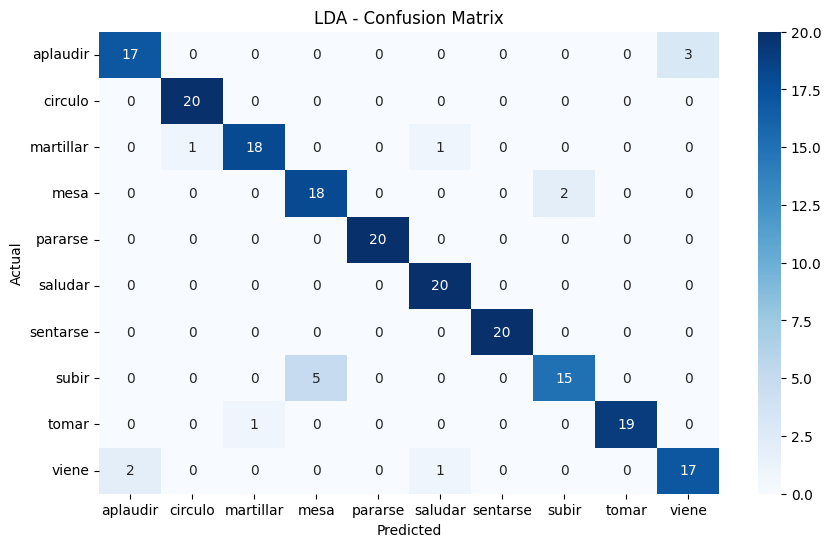

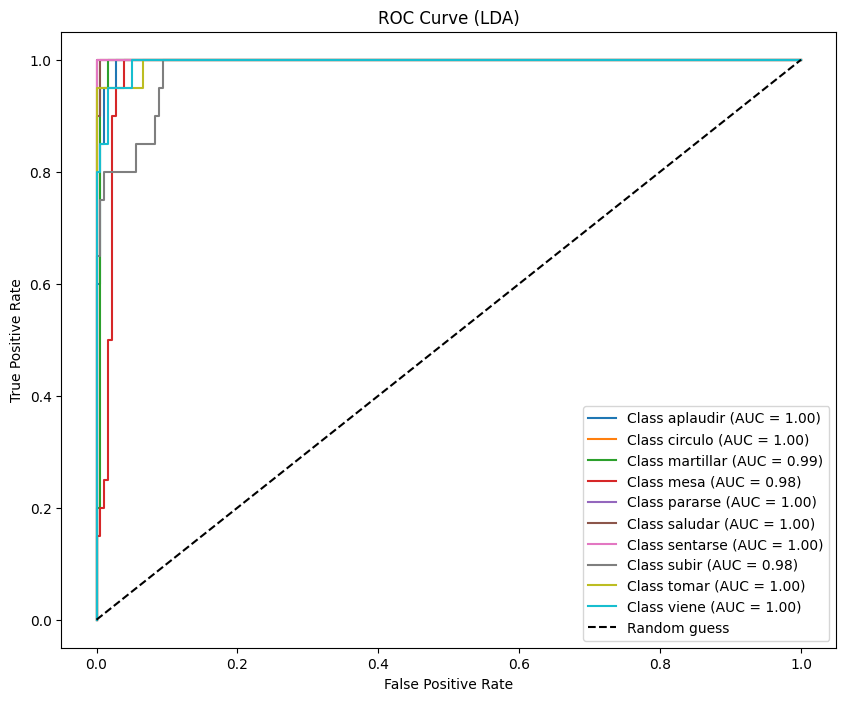

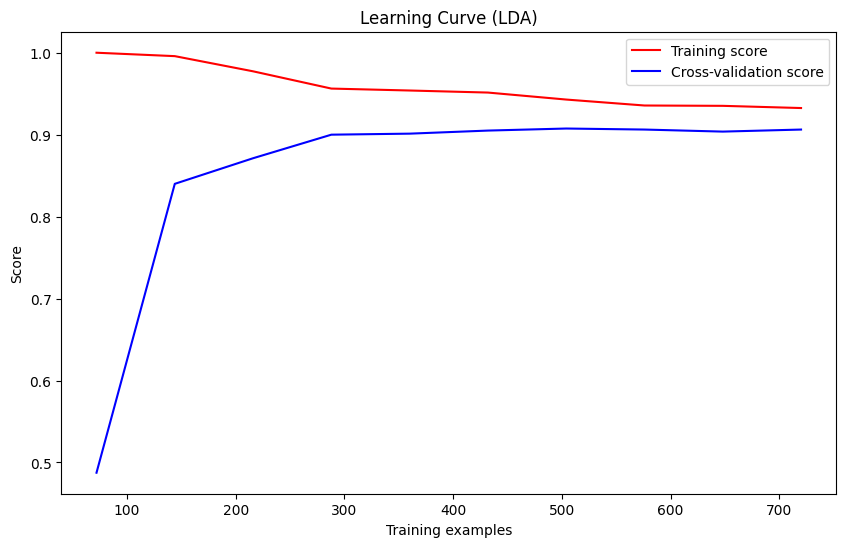

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import uniform
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Cargar los datos
data = pd.read_csv('dataset.csv')
X = data.iloc[:, :64].values
y = data.iloc[:, 64].values

# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modelo LDA
clf = LinearDiscriminantAnalysis(n_components=9)


# Validación cruzada con 10 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Obtener las métricas mediante validación cruzada
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
cross_val_precision = cross_val_score(clf, X_train, y_train, cv=cv, scoring='precision_weighted')
cross_val_recall = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall_weighted')
cross_val_f1 = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_weighted')

# Mostrar los resultados de la validación cruzada
print(f"Cross-Validation Accuracy: {np.mean(cross_val_scores):.2f} ± {np.std(cross_val_scores):.2f}")
print(f"Cross-Validation Precision: {np.mean(cross_val_precision):.2f} ± {np.std(cross_val_precision):.2f}")
print(f"Cross-Validation Recall: {np.mean(cross_val_recall):.2f} ± {np.std(cross_val_recall):.2f}")
print(f"Cross-Validation F1 Score: {np.mean(cross_val_f1):.2f} ± {np.std(cross_val_f1):.2f}")

# Tiempo de entrenamiento
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time

# Predicción y evaluación en el conjunto de prueba
y_pred = clf.predict(X_test)

# Métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"\nTest Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Training time: {train_time:.2f} seconds")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('LDA - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Binarizar las etiquetas para ROC multiclase
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_prob = clf.predict_proba(X_test)

# Graficar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LDA)')
plt.legend(loc='lower right')
plt.show()

# Curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (LDA)")
plt.legend()
plt.show()

## KNN Cosine

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters found: {'n_neighbors': 3}
Training time: 1.37 seconds

### Cross-Validation Results (10 folds) ###
Accuracy scores per fold: [0.9625 0.95   0.9375 0.9625 0.95   0.9625 0.95   0.9625 0.95   0.95  ]
Mean accuracy: 0.95
Standard deviation: 0.01

### Test Set Performance Metrics ###
Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-Score: 0.95


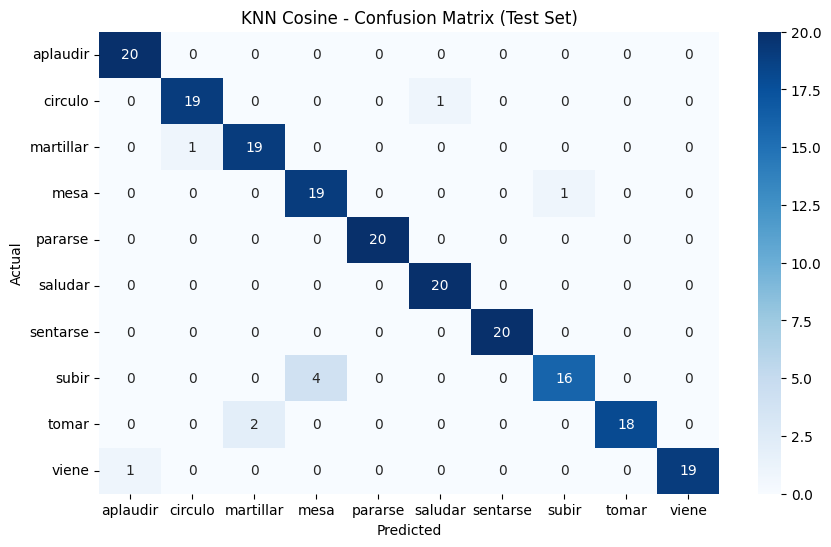

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

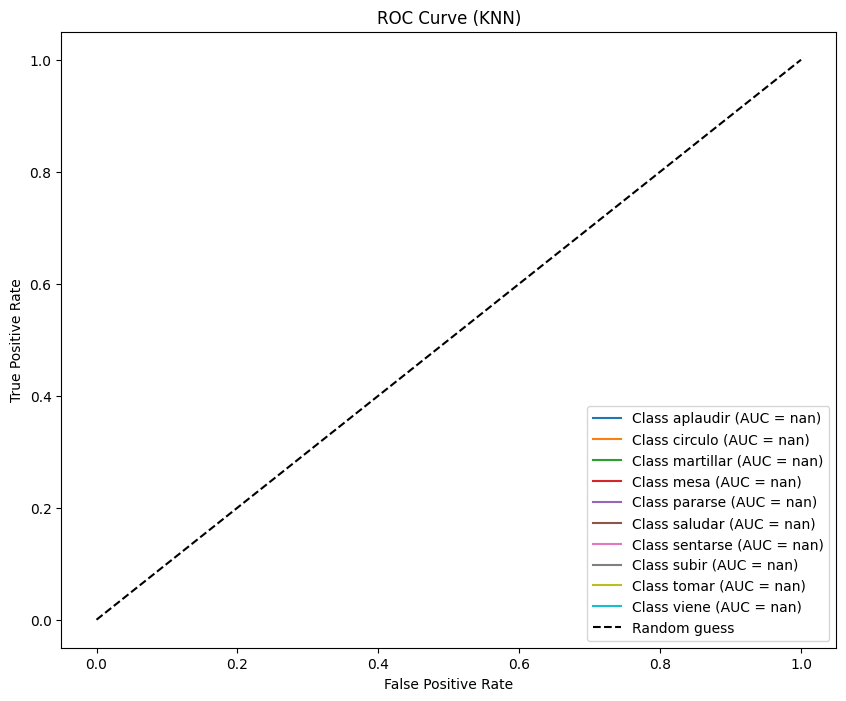

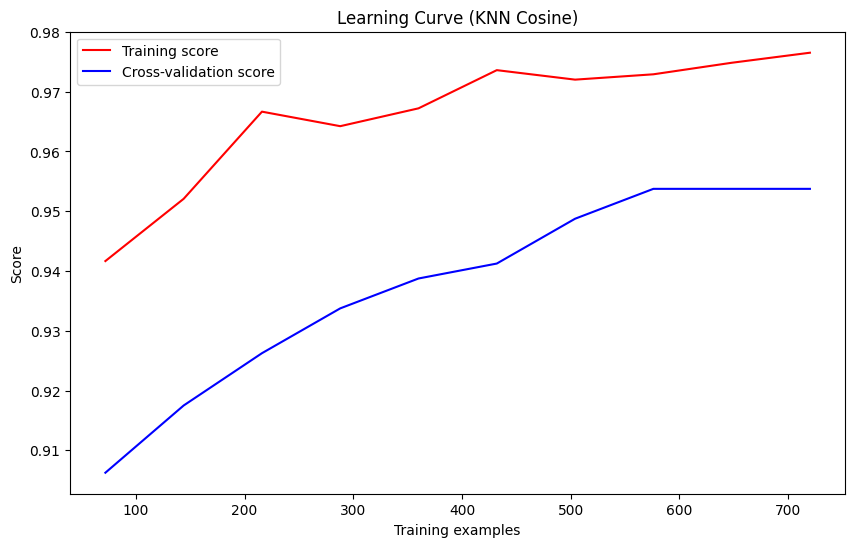

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
# Aplicación de LDA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_scaled, y)
pca=PCA()
X_pca=pca.fit_transform(X_scaled)


# División del conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Crear el codificador de etiquetas
le = LabelEncoder()

# Convertir las etiquetas en el conjunto de entrenamiento y prueba
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Hiperparámetros para RandomizedSearchCV
param_dist = {'n_neighbors': randint(1, 10)}

# Inicializar el clasificador
clf = KNeighborsClassifier(metric='cosine')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # 4 pliegos para la validación cruzada

# Búsqueda aleatoria para encontrar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist,
                                   n_iter=10, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()
random_search.fit(X_train, y_train)
best_knn_model = random_search.best_estimator_
end_time = time.time()
train_time = end_time - start_time

# Resultados de la búsqueda de hiperparámetros
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada
cross_val_scores = cross_val_score(best_knn_model, X_train, y_train, cv=cv, scoring='accuracy')

print("\n### Cross-Validation Results (10 folds) ###")
print(f"Accuracy scores per fold: {cross_val_scores}")
print(f"Mean accuracy: {np.mean(cross_val_scores):.2f}")
print(f"Standard deviation: {np.std(cross_val_scores):.2f}")

# Evaluación del modelo en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Test Set Performance Metrics ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('KNN Cosine - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')
plt.legend(loc='lower right')
plt.show()

# Generar la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (KNN Cosine)")
plt.legend()
plt.show()


# Linear SVM, Quadratic SVM, Cubic SVM, Fifth SVM


## Linear SVM

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters found: {'C': 1, 'class_weight': None, 'kernel': 'linear'}
Training time: 7.60 seconds

Cross-Validation Scores: [0.9125 0.9125 0.95   0.925  0.9    0.9875 0.95   0.95   0.925  0.9125]
Mean CV Accuracy: 0.93
Standard Deviation of CV Accuracy: 0.03

### Model Performance Metrics (Test Set) ###
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-Score: 0.97


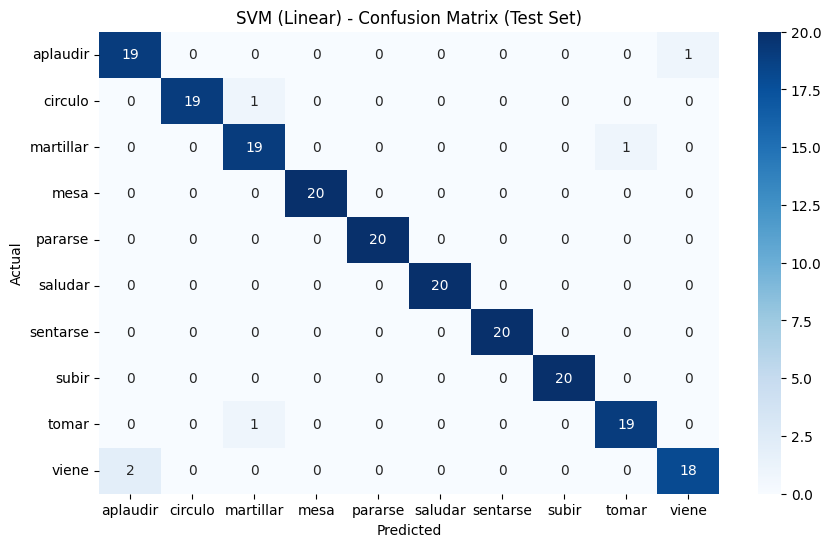

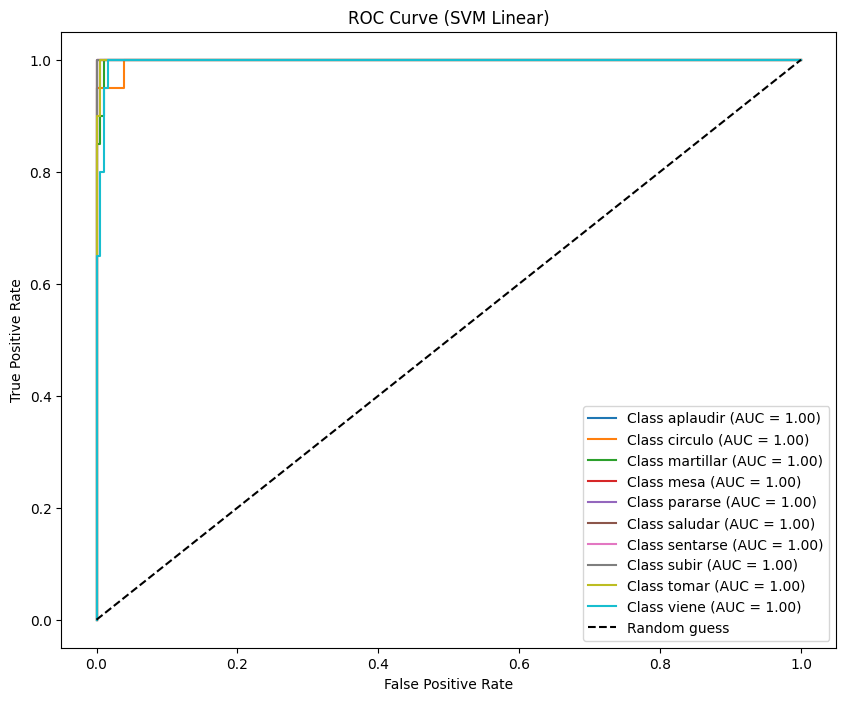

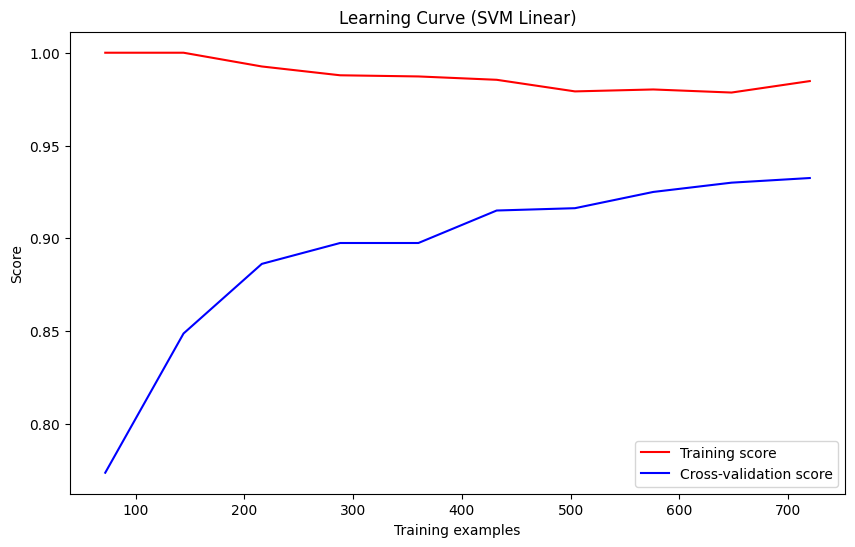

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para la búsqueda
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularización
    'kernel': ['linear'],      # Usar kernel polinomial
    'class_weight': [None, 'balanced']
}

classifier = SVC(probability=True, random_state=0)

# Validación cruzada a 10 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Configurar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,
                           cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

# Tiempo de entrenamiento
start_time = time.time()

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Mejores hiperparámetros encontrados
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada con 10 pliegos en el conjunto de entrenamiento
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")

# Métricas del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Model Performance Metrics (Test Set) ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('SVM (Linear) - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM Linear)')
plt.legend(loc='lower right')
plt.show()

# Curva de aprendizaje con los mejores hiperparámetros
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (SVM Linear)")
plt.legend()
plt.show()


## Quadratic SVM

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'C': 250, 'class_weight': None, 'coef0': 0.3727532183988541}
Training time: 16.40 seconds

Cross-Validation Scores: [0.9125 0.925  0.975  0.9625 0.95   0.9875 0.975  0.975  0.8875 0.9625]
Mean CV Accuracy: 0.95
Standard Deviation of CV Accuracy: 0.03

### Model Performance Metrics (Test Set) ###
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94


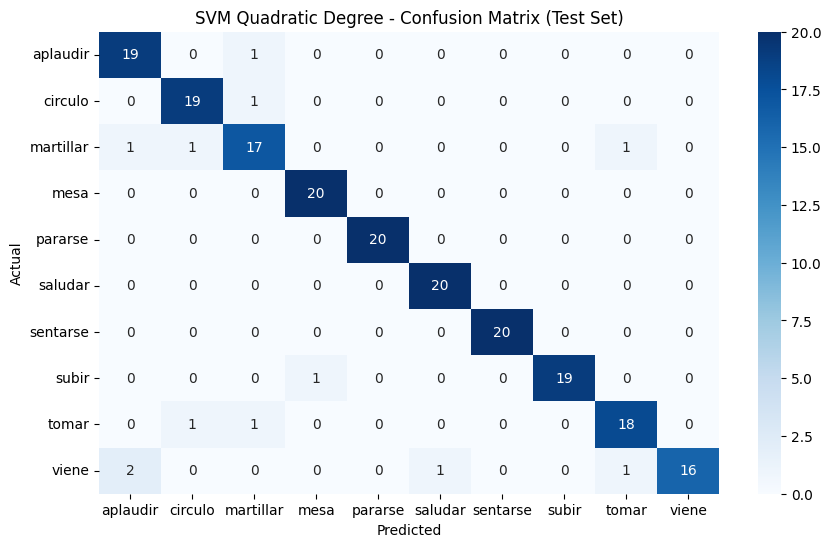

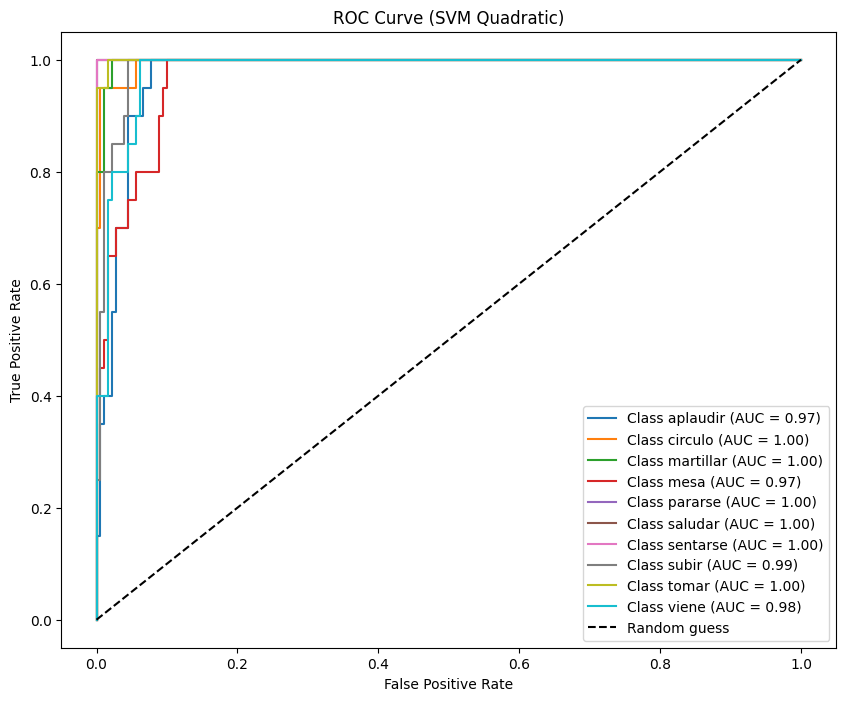

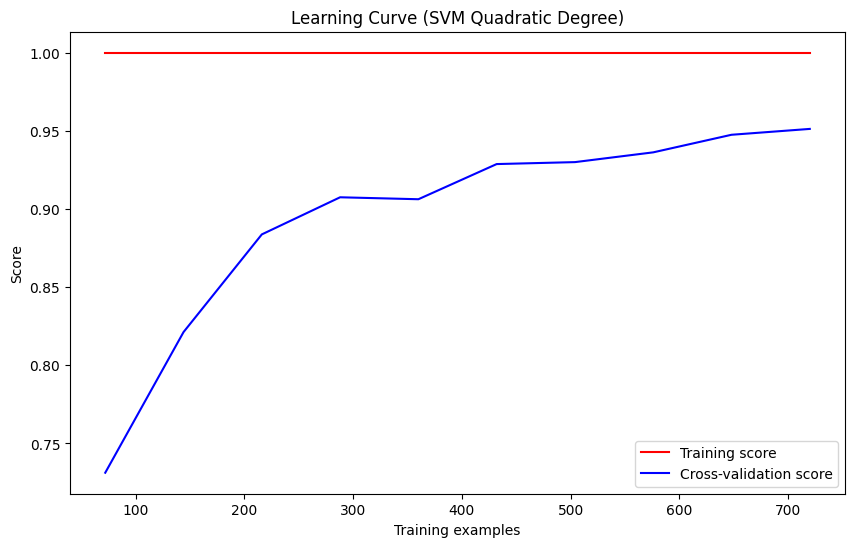

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Escalar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para la búsqueda aleatoria
param_dist = {
    'C': [0.1, 1, 10, 100, 150, 200, 250],  # Regularización
    'coef0': uniform(0, 5),  # Término independiente en el kernel polinomial
    'class_weight': [None, 'balanced']  # Manejo de clases desbalanceadas
}

classifier = SVC(kernel='poly', degree=2, random_state=0)

# Validación cruzada a 10 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=50, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Mejores hiperparámetros encontrados
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada con 10 pliegos en el conjunto de entrenamiento
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")

# Métricas del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Model Performance Metrics (Test Set) ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('SVM Quadratic Degree - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM Quadratic)')
plt.legend(loc='lower right')
plt.show()

# Curva de aprendizaje con los mejores hiperparámetros
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (SVM Quadratic Degree)")
plt.legend()
plt.show()


## Cubic SVM

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'C': 250, 'class_weight': 'balanced', 'coef0': 0.7799726016810132}
Training time: 15.06 seconds

Cross-Validation Scores: [0.9125 0.925  0.975  0.975  0.95   0.9875 0.9875 0.975  0.8875 0.95  ]
Mean CV Accuracy: 0.95
Standard Deviation of CV Accuracy: 0.03

### Model Performance Metrics (Test Set) ###
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94


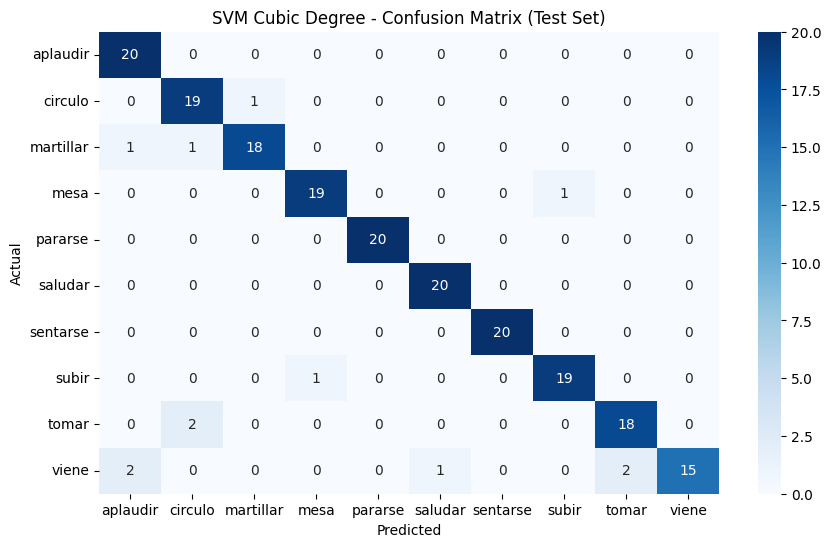

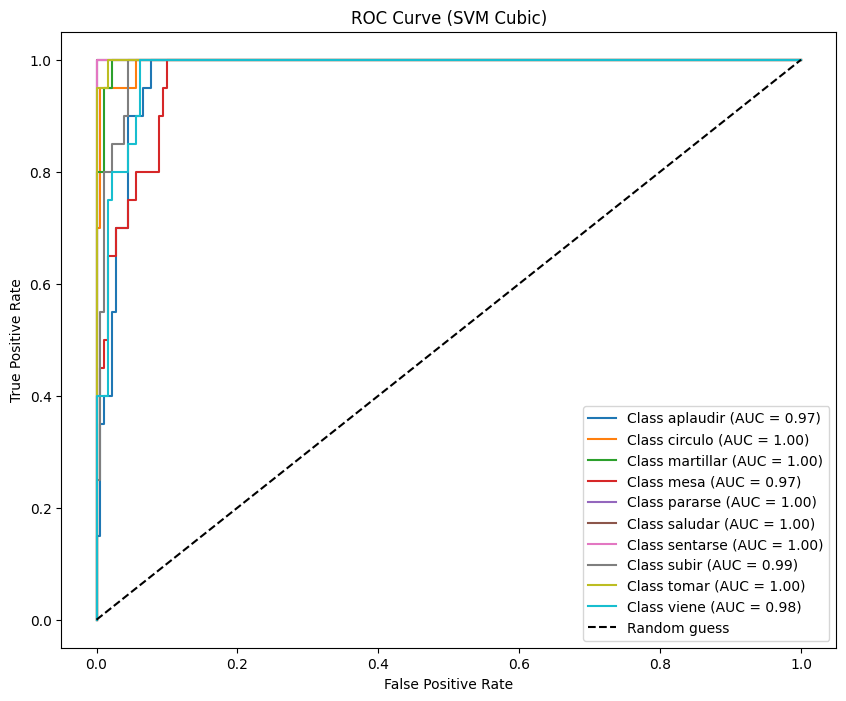

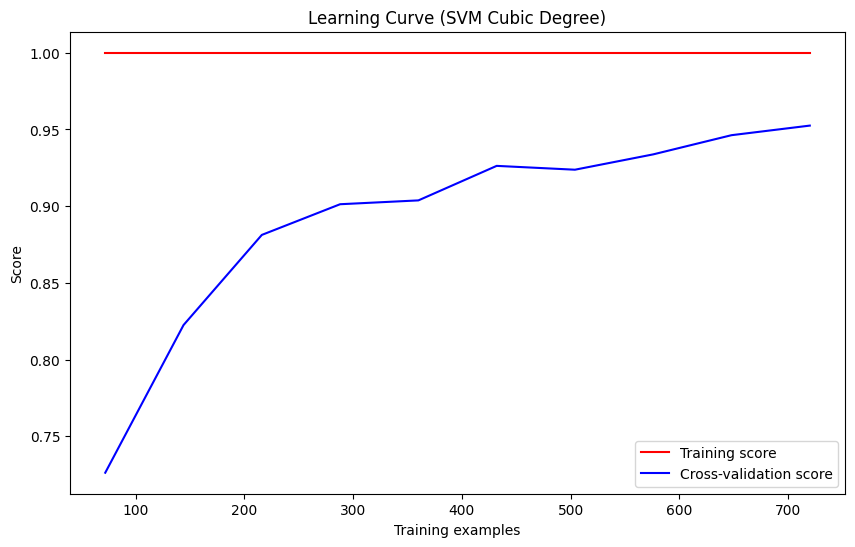

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Escalar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para la búsqueda aleatoria
param_dist = {
    'C': [0.1, 1, 10, 100, 150, 200, 250],  # Regularización
    'coef0': uniform(0, 5),  # Término independiente en el kernel polinomial
    'class_weight': [None, 'balanced']  # Manejo de clases desbalanceadas
}

classifier = SVC(kernel='poly', degree=3, random_state=0)

# Validación cruzada a 10 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=50, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Mejores hiperparámetros encontrados
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada con 10 pliegos en el conjunto de entrenamiento
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")

# Métricas del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Model Performance Metrics (Test Set) ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('SVM Cubic Degree - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM Cubic)')
plt.legend(loc='lower right')
plt.show()

# Curva de aprendizaje con los mejores hiperparámetros
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (SVM Cubic Degree)")
plt.legend()
plt.show()


## FIFTH SVM

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters found: {'C': 0.1, 'class_weight': None, 'coef0': 2.6238733012919457}
Training time: 13.40 seconds

Cross-Validation Scores: [0.9375 0.925  0.975  0.95   0.9625 1.     0.975  0.975  0.9125 0.9125]
Mean CV Accuracy: 0.95
Standard Deviation of CV Accuracy: 0.03

### Model Performance Metrics (Test Set) ###
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94


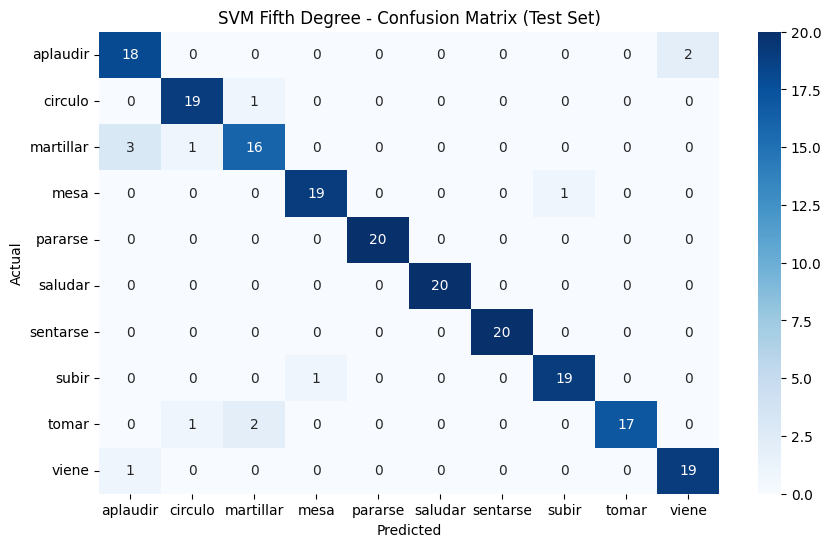

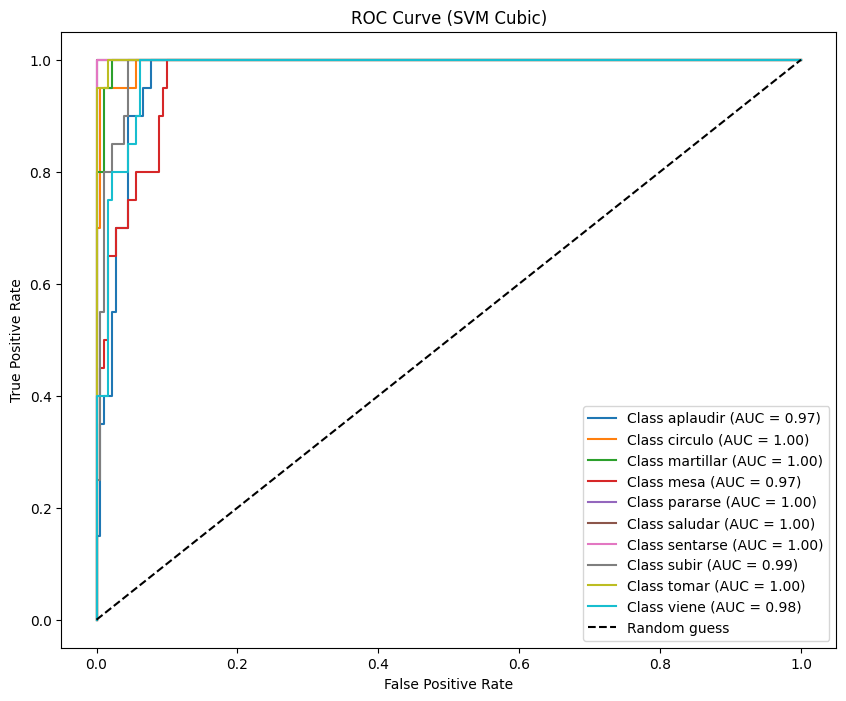

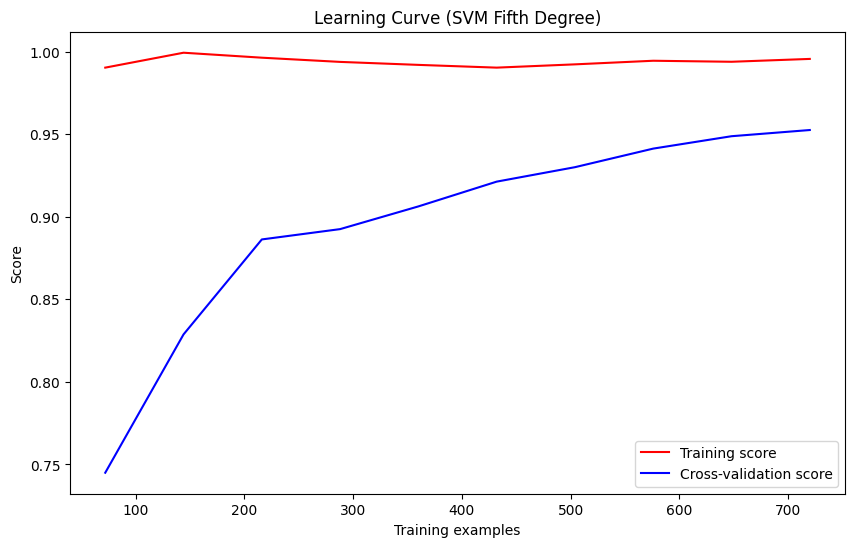

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Cargar el archivo CSV
data = pd.read_csv('dataset.csv')

# Separar predictores y etiquetas
X = data.iloc[:, :64].values  # Las primeras 64 columnas son las variables predictoras
y = data.iloc[:, 64].values   # La última columna (65) es la etiqueta

# Escalar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hiperparámetros para la búsqueda aleatoria
param_dist = {
    'C': [0.1, 1, 10, 100, 150, 200, 250],  # Regularización
    'coef0': uniform(0, 5),  # Término independiente en el kernel polinomial
    'class_weight': [None, 'balanced']  # Manejo de clases desbalanceadas
}

classifier = SVC(kernel='poly', degree=5, random_state=0)

# Validación cruzada a 10 pliegos
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Configurar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist,
                                   n_iter=50, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)

# Tiempo de entrenamiento
start_time = time.time()

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

end_time = time.time()
train_time = end_time - start_time

# Mejores hiperparámetros encontrados
print(f"Best parameters found: {random_search.best_params_}")
print(f"Training time: {train_time:.2f} seconds")

# Validación cruzada con 10 pliegos en el conjunto de entrenamiento
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")

# Métricas del modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Mostrar métricas
print("\n### Model Performance Metrics (Test Set) ###")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('SVM Fifth Degree - Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC y AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM Cubic)')
plt.legend(loc='lower right')
plt.show()

# Curva de aprendizaje con los mejores hiperparámetros
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color='r')
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color='b')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve (SVM Fifth Degree)")
plt.legend()
plt.show()
